In [1]:
import glob
import pandas as pd
cat_df = pd.DataFrame()
cat_df["path"] = glob.glob("train/cat.*.*")
cat_df["target"] = 0
dog_df = pd.DataFrame()
dog_df["path"] = glob.glob("train/dog.*.*")
dog_df["target"] = 1
df = pd.concat([cat_df, dog_df], axis=0, ignore_index=True)
df.head()

,path,target
0,train\cat.0.jpg,0
1,train\cat.1.jpg,0
2,train\cat.10.jpg,0
3,train\cat.100.jpg,0
4,train\cat.1000.jpg,0


In [2]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

C:\Users\laogoon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
#範例～解釋接下來的作法，一層接一層
def test():
    return print
test()(3)

3


In [4]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.layers import BatchNormalization
for l in vgg.layers:
    l.trainable = False
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

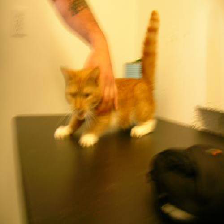

In [5]:
from keras_preprocessing.image import load_img
load_img(df.iloc[0]["path"], target_size=(224, 224))

In [6]:
# 處理階段以後：轉成numpy array
import numpy as np
from sklearn.model_selection import train_test_split
x = np.array(df["path"])
y = np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [7]:
print(x_train.shape)
print(x_test.shape)

(20000,)
(5000,)


In [8]:
from keras.utils.np_utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
print(y_train[-1])
print(y_train_cat[-1])

0
[1. 0.]


In [9]:
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [10]:
# 圖片預處理: 0~1 -> Keras隨機weights
import numpy as np
from keras.applications.vgg16 import preprocess_input
for _ in range(5):
    # numpy randint(起始座號, 結束座號+1, 你要幾個 - batch)
    idx = np.random.randint(0, x_train.shape[0], 20)
    img_list = []
    for p in x_train[idx]:
        img = load_img(p, target_size=(224, 224))
        img_np = np.array(img)
        img_np_pre = preprocess_input(img_np)
        img_list.append(img_np_pre)
    xs = np.array(img_list)
    ys = y_train_cat[idx]
    result = cnn.train_on_batch(xs, ys)
    print("Loss:", result)
    
    validx = np.random.randint(0, x_test.shape[0], 20)
    val_img_list = []
    for p in x_test[validx]:
        img = load_img(p, target_size=(224, 224))
        img_np = np.array(img)
        img_np_pre = preprocess_input(img_np)
        val_img_list.append(img_np_pre)
    xs = np.array(img_list)
    ys = y_test_cat[validx]
    result = cnn.test_on_batch(xs, ys)
    print("VAL Loss:", result)

Loss: [1.4683361, 0.4]
VAL Loss: [6.8426504, 0.5]
Loss: [1.4287211, 0.7]
VAL Loss: [2.570787, 0.65]
Loss: [0.88751745, 0.65]
VAL Loss: [3.901944, 0.5]
Loss: [0.6364721, 0.75]
VAL Loss: [5.393777, 0.45]
Loss: [0.7160467, 0.85]
VAL Loss: [6.173067, 0.45]


In [11]:
validx = np.random.randint(0, x_test.shape[0], 200)
val_img_list = []
for p in x_test[validx]:
    img = load_img(p, target_size=(224, 224))
    img_np = np.array(img)
    img_np_pre = preprocess_input(img_np)
    val_img_list.append(img_np_pre)
xs = np.array(val_img_list)
ys = y_test_cat[validx]
cnn.evaluate(xs, ys)

200/200 [==============================] - 2s 12ms/step


[0.84201664686203, 0.87]